In [1]:
from SYK_fft import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from ConformalAnalytical import *
import time


\begin{align}
    \Sigma(\tau) &= g^2 G(\tau)D(\tau) \\
    \Pi(\tau) &= -2g^2 G(\tau)G(-\tau) \\
    G(\omega_n) &= \frac{1}{i\omega_n + \mu - \Sigma(\omega_n)}\\
    D(\nu_n) &= \frac{1}{\nu_n^2 + r - \Pi(\nu_n)}
\end{align}    



In [2]:
Nbig = int(2**16)
err = 1e-6

beta = 100
mu = 0.0
g = 0.5
#r = 0.0 + 1e-8 * 1j
r = 1.
#r = g**2 * beta/2 + 0.001
kappa = 1.

omega = (2 * np.arange(Nbig) - Nbig + 1) * np.pi/beta
nu = (2 * np.arange(Nbig) - Nbig ) * np.pi/beta
tau = (np.arange(Nbig) + 1./2) * beta/Nbig

In [3]:
Gfreetau = Freq2TimeF(1./(1j*omega + mu),Nbig,beta)
Dfreetau = Freq2TimeB(1./(nu**2 + r),Nbig,beta)
delta = 0.420374134464041
Gtau_powerlaw = -1.0*np.sign(tau)/np.abs(np.sin(np.pi*tau/beta)) ** (2*delta)
Dtau_powerlaw =  1.0/np.abs(np.sin(np.pi*tau/beta)) ** (2 - 4*delta)

#Gtau = Gfreetau
#Dtau = Dfreetau

#Gtau = Freq2TimeF(GconfImag(omega,g,beta),Nbig,beta)
#Dtau = Freq2TimeB(DconfImag(nu,g,beta),Nbig,beta)

Gtau = Gtau_powerlaw * (-0.5/Gtau_powerlaw[0])
Dtau = Dtau_powerlaw * (DfreeImagtau(tau,r,beta)/Dtau_powerlaw[0])

itern = 0
diff = 1.
diffG = 1.
diffD = 1.
x = 0.5
xG = 0.5
xD = 0.5

while(diff>err):
#while(itern<1):
    itern+=1
    diffold = 1.0*diff
    diffoldG = 1.0*diffG
    diffoldD = 1.0*diffD
    
    oldGtau = 1.0*Gtau
    oldDtau = 1.0*Dtau
    
    oldGomega = Time2FreqF(oldGtau,Nbig,beta)
    oldDomega = Time2FreqB(oldDtau,Nbig,beta)
    
    Sigmatau = 1.0 * kappa * (g**2) * Dtau * Gtau
    Pitau = 2.0 * g**2 * Gtau * Gtau[::-1] #KMS G(-tau) = -G(beta-tau)
    
    Sigmaomega = Time2FreqF(Sigmatau,Nbig,beta)
    Piomega =  Time2FreqB(Pitau,Nbig,beta)
    
    Gomega = xG*(1./(1j*omega + mu - Sigmaomega)) + (1-xG)*oldGomega
    Domega = xD*(1./(nu**2 + r - Piomega)) + (1-xD)*oldDomega
    #Domega = Domega - np.imag(Domega)
   
    #Gtau = Freq2TimeF(Gomega - (1./(1j*omega)),Nbig,beta) - 0.5
    #Dtau = Freq2TimeB(Domega - (1./(nu**2+r)),Nbig,beta) + DfreeImagtau(tau,r,beta)
    Gtau = Freq2TimeF(Gomega,Nbig,beta)
    Dtau = Freq2TimeB(Domega,Nbig,beta)
    
    diffG = np. sqrt((1.0/Nbig) * np.sum((np.abs(Gtau-oldGtau))**2)) #changed
    diffD = np. sqrt((1.0/Nbig) * np.sum((np.abs(Dtau-oldDtau))**2))
    diff = np.max([diffG,diffD])
    
    if diffG>diffoldG:
        xG/=2.
    if diffD>diffoldD:
        xD/=2.
    print("itern = ",itern, " , diff = ", diffG,diffD, " , x = ", xG,xD, end = '\r')


    
#print("itern = ",itern, " , diff = ", diff, " , x = ", xG,xD, end = '\r')


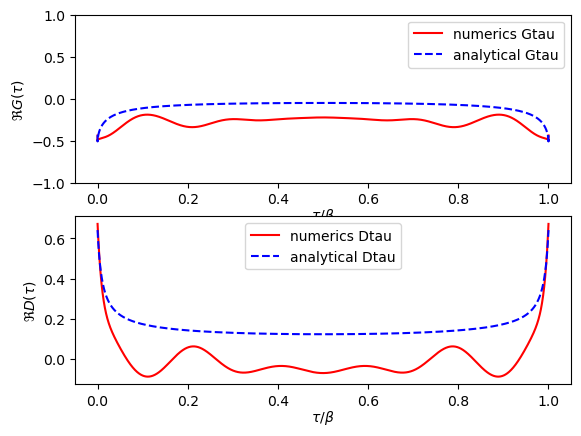

In [4]:
Gconftau = Freq2TimeF(GconfImag(omega,g,beta),Nbig,beta)
Dconftau = Freq2TimeB(DconfImag(nu,g,beta),Nbig,beta)
FreeDtau = DfreeImagtau(tau,r,beta)

fig, ax = plt.subplots(2)

ax[0].plot(tau/beta, np.real(Gtau), 'r', label = 'numerics Gtau')
ax[0].plot(tau/beta, np.real(Gconftau), 'b--', label = 'analytical Gtau' )
ax[0].set_ylim(-1,1)
ax[0].set_xlabel(r'$\tau/\beta$',labelpad = 0)
ax[0].set_ylabel(r'$\Re{G(\tau)}$')
ax[0].legend()

ax[1].plot(tau/beta, np.real(Dtau), 'r', label = 'numerics Dtau')
ax[1].plot(tau/beta, np.real(Dconftau), 'b--', label = 'analytical Dtau' )
#ax[1].plot(tau/beta, np.real(FreeDtau), 'g-.', label = 'Free D Dtau' )
#ax[1].set_ylim(0,1)
ax[1].set_xlabel(r'$\tau/\beta$',labelpad = 0)
ax[1].set_ylabel(r'$\Re{D(\tau)}$')
ax[1].legend()


Text(42.597222222222214, 0.5, '$\\Im{D(\\nu_n)}$')

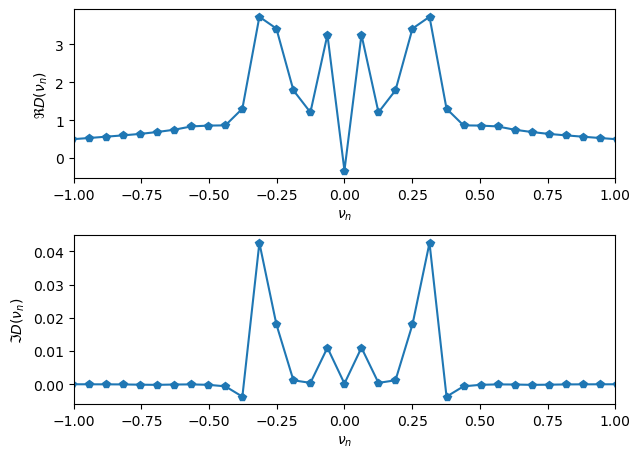

In [5]:
fig, (ax1,ax2) = plt.subplots(2)
fig.tight_layout(pad=2)

ax1.plot(nu, np.real(Domega),'p-')
ax1.set_xlim(-1,1)
ax1.set_xlabel(r'$\nu_n$')
ax1.set_ylabel(r'$\Re{D(\nu_n)}$')

ax2.plot(nu, np.imag(Domega),'p-')
ax2.set_xlim(-1,1)
ax2.set_xlabel(r'$\nu_n$')
ax2.set_ylabel(r'$\Im{D(\nu_n)}$')

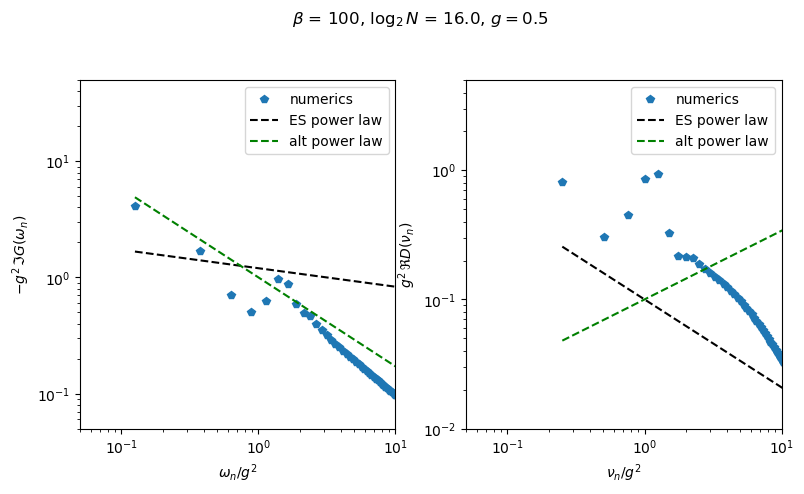

In [12]:
start, stop = Nbig//2, Nbig-1
startB = Nbig//2 + 1 
delta = 0.420374134464041
alt_delta = 0.116902  
conf_fit_G = 1.2 * np.abs(omega/(g**2))**(2*delta - 1)
alt_conf_fit_G = 1.0 * np.abs(omega/(g**2))**(2*alt_delta - 1)
conf_fit_D = 0.1 * np.abs(nu[startB:]/(g**2))**(1-4*delta)
alt_conf_fit_D = 0.1 * np.abs(nu[startB:]/(g**2))**(1-4*alt_delta)
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(8)
titlestring = r'$\beta$ = ' + str(beta) + r', $\log_2{N}$ = ' + str(np.log2(Nbig)) + r', $g = $' + str(g)
fig.suptitle(titlestring)
fig.tight_layout(pad=2)

ax1.loglog(omega[start:]/(g**2), -np.imag(Gomega[start:])*(g**2),'p',label = 'numerics')
ax1.loglog(omega[start:]/(g**2), conf_fit_G[start:],'k--',label = 'ES power law')
ax1.loglog(omega[start:]/(g**2), alt_conf_fit_G[start:],'g--', label = 'alt power law')
ax1.set_xlim(5e-2,10)
ax1.set_ylim(5e-2,50)
ax1.set_xlabel(r'$\omega_n/g^2$')
ax1.set_ylabel(r'$-g^2\,\Im{G(\omega_n)}$')
ax1.legend()
#titlestring1 = r'$\beta$ = ' + str(beta) + r'     $\log_2{N}$ = ' + str(np.log2(Nbig))
#ax1.set_title(titlestring1)

ax2.loglog(nu[startB:]/(g**2), np.real(Domega[startB:])*(g**2),'p',label='numerics')
ax2.loglog(nu[startB:]/(g**2), conf_fit_D,'k--',label = 'ES power law')
ax2.loglog(nu[startB:]/(g**2), alt_conf_fit_D,'g--', label = 'alt power law')
ax2.set_xlim(5e-2,10)
ax2.set_ylim(1e-2,5)
ax2.set_xlabel(r'$\nu_n/g^2$')
ax2.set_ylabel(r'$g^2\,\Re{D(\nu_n)}$',labelpad = None)
ax2.legend()
#titlestring2 = r'$\beta$ = ' + str(beta) + r'     $\log_2{N}$ = ' + str(np.log2(Nbig))
#ax2.set_title(titlestring)



In [7]:
Piomega[Nbig//2] * Domega[Nbig//2], Gomega[Nbig//2] * Sigmaomega[Nbig//2]

((-1.306635039311406+0.0001778746811422104j),
 (1.5862011143261558-1.8006114060203966e-05j))

In [8]:
np.allclose(np.imag(Domega),np.zeros_like(Domega))

False

In [9]:
omega[Nbig//2], nu[Nbig//2]

(0.031415926535897934, 0.0)

In [10]:
Piconftau = 2.0 * g**2 * Gconftau * Gconftau[::-1] #KMS G(-tau) = -G(beta-tau)
Piconfomega = Time2FreqB(Piconftau,Nbig,beta)
Dconfomega = Time2FreqB(Dconftau,Nbig,beta)
prodD = Dconfomega * Piconfomega 
print(np.real(prodD[Nbig//2 - 5: Nbig//2+5]))

Sigmaconftau = g**2 * Dconftau * Gconftau 
Sigmaconfomega = Time2FreqF(Sigmaconftau,Nbig,beta)
Gconfomega = Time2FreqF(Gconftau,Nbig,beta)
prodG = Gconfomega * Sigmaconfomega 
print(np.real(prodG[Nbig//2 - 5: Nbig//2+5]))

[ 0.21499208  0.29317681  0.42277599  0.66893485  1.28831391 10.047778
  1.28831391  0.66893485  0.42277599  0.29317681]
[-0.20764244 -0.25071171 -0.31306237 -0.41347545 -0.63299198 -0.63299198
 -0.41347545 -0.31306237 -0.25071171 -0.20764244]
